# import the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

%matplotlib inline

# Load the data

In [2]:
train = pd.read_csv('train.csv',encoding = 'latin-1')
test= pd.read_csv('test.csv',encoding = 'latin-1')
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [414]:
test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [415]:
train['sentiment'].value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

In [416]:
train.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [417]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
sentiment    15819 non-null int64
message      15819 non-null object
tweetid      15819 non-null int64
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


# explotary data analysis

In [418]:
train.describe()

,sentiment,tweetid
count,15819.000000,15819.000000
mean,0.917504,501719.433656
std,0.836537,289045.983132
min,-1.000000,6.000000
25%,1.000000,253207.500000
50%,1.000000,502291.000000
75%,1.000000,753769.000000
max,2.000000,999888.000000


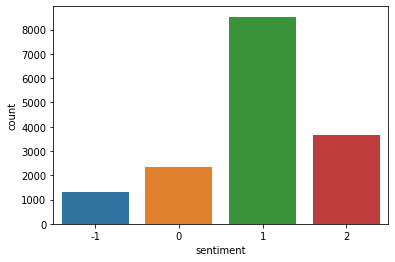

In [445]:
sns.countplot(x= 'sentiment',data = train)

Text(0, 0.5, 'Density')

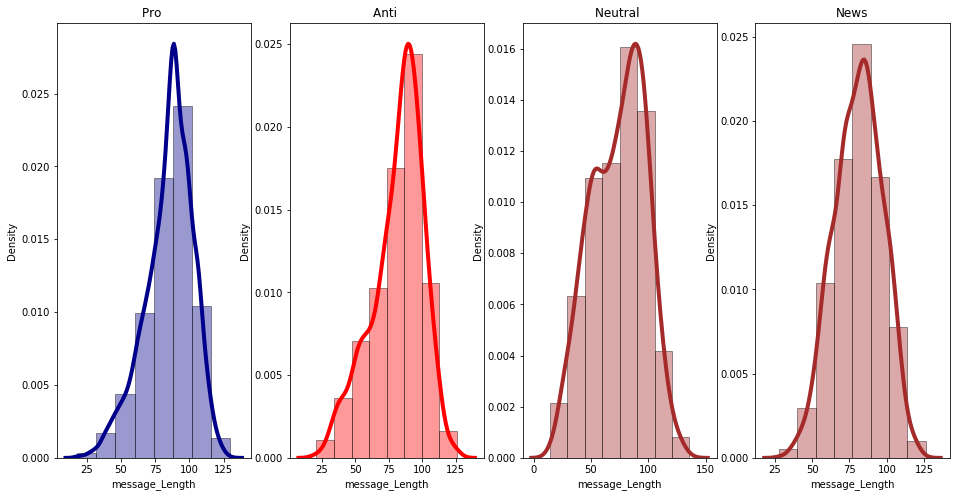

In [37]:

fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(16,8))

#For Positive 
sns.distplot(train[train['sentiment']==1]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'darkblue', 
             ax = ax1,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax1.set_title('Pro ')
ax1.set_xlabel('message_Length')
ax1.set_ylabel('Density')

#For Negative 
sns.distplot(train[train['sentiment']==-1]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'red', 
             ax = ax2,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax2.set_title('Anti ')
ax2.set_xlabel('message_Length')
ax2.set_ylabel('Density')

#For Neutral 
sns.distplot(train[train['sentiment']==0]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'brown', 
             ax = ax3,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax3.set_title('Neutral ')
ax3.set_xlabel('message_Length')
ax3.set_ylabel('Density')

#For Neews
sns.distplot(train[train['sentiment']==2]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'brown', 
             ax = ax4,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax4.set_title('News')
ax4.set_xlabel('message_Length')
ax4.set_ylabel('Density')

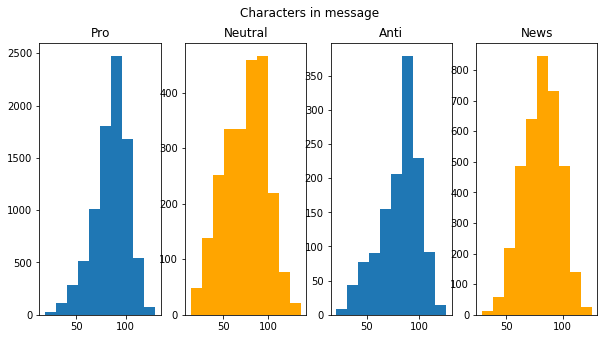

In [38]:
#Distribution of  characters in train data
fig,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(10,5))
train_len=train[train['sentiment']==1]['message'].str.len()
ax1.hist(train_len)
ax1.set_title('Pro')
train_len=train[train['sentiment']==0]['message'].str.len()
ax2.hist(train_len, color="orange")
ax2.set_title('Neutral')
train_len=train[train['sentiment']==-1]['message'].str.len()
ax3.hist(train_len)
ax3.set_title('Anti')
train_len=train[train['sentiment']==2]['message'].str.len()
ax4.hist(train_len, color="orange")
ax4.set_title('News')


fig.suptitle('Characters in message')
plt.show()

# cleaning data

In [13]:
train.drop(['tweetid'],axis=1,inplace=True)
test.drop(['tweetid'],axis=1,inplace=True)

In [14]:
# Remove urls
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
train['message'] = train['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)

In [15]:
train.head()

,sentiment,message
0,1,PolySciMajor EPA chief doesn't think carbon di...
1,1,It's not like we lack evidence of anthropogeni...
2,2,RT @RawStory: Researchers say we have three ye...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ..."


In [16]:
def remove_pattern(text, pattern):
    r = re.findall(pattern, text)
    for i in r:
        text = re.sub(i, '', text)
    return text

# remove 'RT' handle
train['message'] = np.vectorize(remove_pattern)(train['message'], "RT")
test['message'] = np.vectorize(remove_pattern)(test['message'], "RT")

In [17]:
# Make lower case
train['message'] = train['message'].str.lower()

In [18]:
# Strip out punctuation marks and numerals
import string
def remove_punctuation_numbers(post):
    punc_numbers = string.punctuation + '0123456789'
    return ''.join([l for l in post if l not in punc_numbers])

train['message'] = train['message'].apply(remove_punctuation_numbers)

In [19]:
train.head()

,sentiment,message
0,1,polyscimajor epa chief doesnt think carbon dio...
1,1,its not like we lack evidence of anthropogenic...
2,2,rawstory researchers say we have three years ...
3,1,todayinmaker wired was a pivotal year in the...
4,1,soynoviodetodas its and a racist sexist clim...


# Tokenisation

In [39]:
from nltk.tokenize import word_tokenize, TreebankWordTokenizer

In [40]:
tokeniser = TreebankWordTokenizer()
train['message'] = train['message'].apply(tokeniser.tokenize)
test['message'] = test['message'].apply(tokeniser.tokenize)

In [42]:
train['message']

0        [polyscimajor, epa, chief, doesnt, think, carb...
1        [like, lack, evidence, anthropogenic, global, ...
2        [rawstory, researchers, say, years, act, clima...
3        [todayinmaker, wired, pivotal, year, war, clim...
4        [soynoviodetodas, racist, sexist, climate, cha...
                               ...                        
15814    [ezlusztig, took, material, global, warming, l...
15815    [washingtonpost, climate, change, breaking, mi...
15816    [notiven, nytimesworld, does, trump, actually,...
15817    [sarasmiles, hey, liberals, climate, change, c...
15818    [chetcannon, kurteichenwalds, climate, change,...
Name: message, Length: 15819, dtype: object

In [48]:
# As usual, we start by importing our modules
from sklearn.utils import resample

# Split the data

In [23]:
X = train['message']
y = train['sentiment']

In [24]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Build pipelines to vectorize the data, then train and fit a model

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC


# Linear SVC:
text_clf_lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])

# fit train data

# Linear SVC

In [26]:
text_clf_lsvc.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
               

In [27]:
# Form a prediction set
predictions = text_clf_lsvc.predict(X_test)

In [28]:
# Report the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))

[[ 199   52  157   20]
 [  29  319  324   65]
 [  27  163 2430  241]
 [   5   24  254  912]]


In [29]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

          -1       0.77      0.46      0.58       428
           0       0.57      0.43      0.49       737
           1       0.77      0.85      0.81      2861
           2       0.74      0.76      0.75      1195

    accuracy                           0.74      5221
   macro avg       0.71      0.63      0.66      5221
weighted avg       0.73      0.74      0.73      5221



In [30]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

0.7393219689714614


In [33]:
# Form a prediction set
predictions = text_clf_nb.predict(X_test)